In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from apollon.audio import load_audio
from apollon.hmm.poisson import PoissonHmm
from apollon.signal.spectral import Stft, Dft
from apollon.signal.features import spectral_centroid
from apollon.onsets import FluxOnsetDetector
from apollon import segment

# Hidden Markov Models as timbre-based rhythm models

In [2]:
audio_files = ('../audio/base.wav', '../audio/var1.wav', '../audio/var2.wav')
sounds = [load_audio(file) for file in audio_files]

## 1. Preprocessing

In [3]:
fps = 44100           # audio frames per second
window = 'hamming'    # window function to apply to segments
n_perseg = 1024       # length of each segment in samples
n_overlap = 512       # number of overlapping samples

## 1.1 Onset detection

In [4]:
onsets = []
for snd in sounds:
    fod = FluxOnsetDetector(fps, window, n_perseg, n_overlap)
    fod.detect(snd.data.ravel())
    onsets.append(fod.onsets)

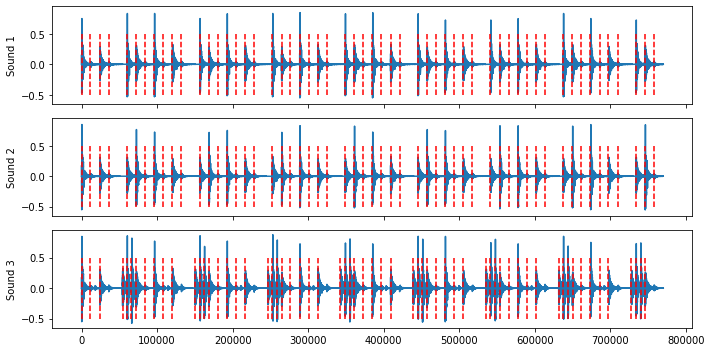

In [30]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True, sharey=True)
for i, (ax, snd, ons) in enumerate(zip(axs, sounds, onsets)): 
    ax.set_ylabel(f'Sound {i+1}')
    ax.plot(snd.data.ravel(), zorder=-1)
    ax.vlines(ons.frame, -0.5, 0.5, 'r', 'dashed', zorder=1)
fig.tight_layout()

## 1.2 Feature extraction

In [5]:
dft = Dft(fps, window)

In [6]:
centroids = []
for snd, ons in zip(sounds, onsets):
    segs = segment.by_onsets(snd.data.ravel(), 1024, ons.frame)
    spctr = dft.transform(segs.T)
    cn = spectral_centroid(spctr.frqs, spctr.power).ravel()
    centroids.append(cn)

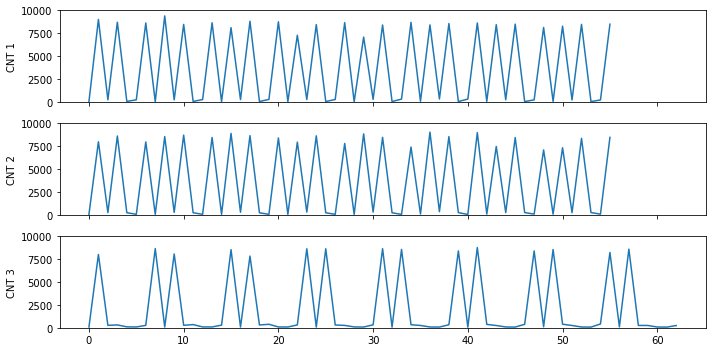

In [26]:
fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=True, sharey=True)
for i, (ax, cnt) in enumerate(zip(axs, centroids)): 
    ax.set_ylabel(f'CNT {i+1}')
    ax.set_ylim([0, 10000])
    ax.plot(cnt)
fig.tight_layout()

## 1.3 Prepare features for HMM

This particular HMM uses Poisson distributions as components. These are discrete distributions. Hence, the feature values must be discretized.
In this case, the spectral centroid frequencies are rounded to the next integer. Additionally, features must be rescaled to support numerical stability
of the algorithm

In [9]:
scaler = MinMaxScaler((1, 500))

scaled_features = []
for cnt in centroids:
    scaled_features.append(scaler.fit_transform(cnt.reshape(-1, 1)).ravel().round().astype(int))

## 2. Estimate HMM parameters

In [131]:
m = 4    # number HMM states a.k.a. number of component distributions

In [138]:
hmms = []
for feat in scaled_features:
    mod = PoissonHmm(feat, m)
    mod.fit(feat)
    hmms.append(mod)

In [303]:
a = hmms[0]

In [306]:
hmms[0].params

Lambda:
[  1.6875  13.1875 439.25   455.625 ]

Gamma:
[[0.  0.5 0.5 0. ]
 [0.  0.  0.  1. ]
 [0.  1.  0.  0. ]
 [1.  0.  0.  0. ]]

Delta:
[1. 0. 0. 0.]

In [127]:
hmms[1].params

Lambda:
[  1.9988  12.7361 458.625 ]

Gamma:
[[0.     0.     1.    ]
 [0.4993 0.     0.5007]
 [0.3034 0.6966 0.    ]]

Delta:
[1. 0. 0.]

In [128]:
hmms[2].params

Lambda:
[ 2. 12. 20.]

Gamma:
[[0.8 0.1 0.1]
 [0.1 0.8 0.1]
 [0.1 0.1 0.8]]

Delta:
[0.3333 0.3333 0.3333]